In [7]:
import pandas as pd
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import models
import random
import torch
import torch.nn as nn
import torch.optim as optim
import PIL
import torchvision
import tqdm
import cv2
import matplotlib.pyplot as plt
import os
import shutil
import sklearn

In [8]:
os.chdir('/Users/jiasong/Desktop')
folder_path = ('LightData')

file_path = []
for root, dir, files in os.walk(folder_path):
    for f in files:
        if f=='.DS_Store':
            continue
        file_info = os.path.join(root, f)
        file_path.append(file_info)

lst = [e[10:] for e in file_path]
lst[0:5]

['Green/Light_Green_65.jpg',
 'Green/Light_Green_71.jpg',
 'Green/Light_Green_59.jpg',
 'Green/Light_Green_136.jpg',
 'Green/Light_Green_122.jpg']

In [9]:
classes = []
for i in lst:
    split = i.split('/')[0]
    classes.append(split)
classes[700:705]

['Green_Right', 'Green_Right', 'Green_Right']

In [10]:
df1 = pd.DataFrame(lst,columns=['FILE'])
df2 = pd.DataFrame(classes, columns=['CLASS'])
df1.insert(0,'ID',range(0,len(df1)))
df2.insert(0,'ID',range(0,len(df2)))
result = pd.merge(df1, df2, on='ID')
result.head(n=5)

,ID,FILE,CLASS
0,0,Green/Light_Green_65.jpg,Green
1,1,Green/Light_Green_71.jpg,Green
2,2,Green/Light_Green_59.jpg,Green
3,3,Green/Light_Green_136.jpg,Green
4,4,Green/Light_Green_122.jpg,Green


In [11]:
train_path = 'LabData/train'
if not os.path.exists(train_path):
    os.makedirs(train_path)

test_path = 'LabData/test'
if not os.path.exists(test_path):
    os.makedirs(test_path)
    


In [12]:
from torchvision.transforms.transforms import CenterCrop


class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return torchvision.transforms.functional.pad(image, padding, 0, 'constant')


mean = [0.4829, 0.4908, 0.4228]
std = [0.2297, 0.2252, 0.2601]

transform = torchvision.transforms.Compose(
    [
      SquarePad(),
      torchvision.transforms.RandomHorizontalFlip(p = 0.5),
      torchvision.transforms.RandomVerticalFlip(p = 0.5),
      torchvision.transforms.Resize(224),
      #torchvision.transforms.CenterCrop(224),
      #torchvision.transforms.RandomResizedCrop(224, (0.8, 1.0)),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(
          mean=mean,
          std=std
          )
    ]
)

train = torchvision.datasets.ImageFolder(
    root = 'LabData/train/',
    transform = transform
)


train_loader = torch.utils.data.DataLoader(
    train, 
    batch_size= 64,
    shuffle=True,
    num_workers=0
)

test = torchvision.datasets.ImageFolder(
    root = 'LabData/test/',
    transform = transform
)


test_loader = torch.utils.data.DataLoader(
    test, 
    batch_size= 64,
    shuffle=True,
    num_workers=0
)

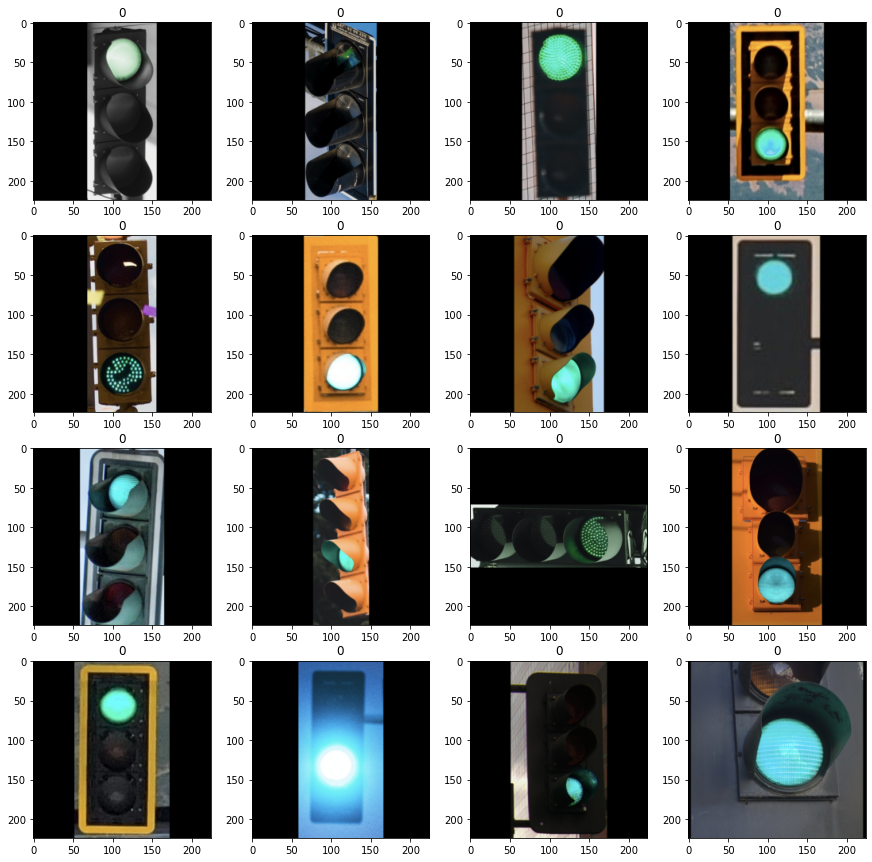

In [13]:
fig,axes= plt.subplots(4,4,figsize=(15,15))
for i in range(16):
    img= train[i][0].numpy().transpose(1, 2,0)
    img=np.clip((std * img)+ mean,0,1)
    axes.flat[i].imshow(img)
    axes.flat[i].set_title(str(train[i][1]))
plt.show()

In [14]:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 200)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = self.bn2(x)
        x = self.fc2(x)
        return x

# if torch.cuda.is_available():
#   cuda = True
ResNet_34 = Net()

# if cuda:
#   ResNet_34.cuda()
print(ResNet_34)

Net(
  (top_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [15]:
optimizer = optim.SGD(params = ResNet_34.parameters(),   lr= 1e-3, momentum= 0.9 )
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = nn.CrossEntropyLoss()

In [16]:
from datetime import datetime
import tqdm as tqdm

EPOCHS = 50  # 50

train_loss = [np.nan]
train_accuracy = [np.nan]
test_loss = [np.nan]

ResNet_34.train()

pbar = tqdm.tqdm(total=EPOCHS, position=0, leave=True)
pbar.set_description("EPOCH 1: Training Loss: NA, ")


for epoch in range(EPOCHS):
    total, correct, running_loss = 0, 0, 0
    for batch_idx, (data, target) in enumerate(train_loader):
        ResNet_34.train()
        #if cuda:
            #data, target = data.cuda(), target.cuda()
    
    optimizer.zero_grad()

    out = ResNet_34(data)

    loss = criterion(out, target)
    loss.backward()
    optimizer.step()

    current_loss = loss.cpu().data.item()
    running_loss += current_loss

    _, predicted = out.max(1)
    total += target.size(0)
    correct += predicted.eq(target).sum().cpu().item()

    pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}\t Test Loss: {test_loss[-1]:.3f}\t")

    test_running_loss = 0
    ResNet_34.eval()

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            #if cuda:
                #data, target = data.cuda(), target.cuda()

            out = ResNet_34(data)

            loss = criterion(out, target)

            test_running_loss += loss.cpu().data.item()

        LTest = test_running_loss/len(test_loader)

    LTrain = running_loss/len(train_loader)
    accu = 100.*correct/total

    train_accuracy.append(accu)
    train_loss.append(LTrain)
    test_loss.append(LTest)

    pbar.set_description(
      f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}\t Test Loss: {test_loss[-1]:.3f}\t")

    pbar.update()

del train_accuracy[0]
del train_loss[0]
del test_loss[0]

EPOCH 50	 Batch Loss: 3.034	  Epoch Loss: 0.337	 Train Acc: 70.213	 Test Loss: 3.815	: 100%|██████████| 50/50 [50:58<00:00, 66.49s/it]

In [17]:
def save_model(m, p):
    torch.save(m.state_dict(), p)
    
def load_model(m, p):
    m.load_state_dict(torch.load(p))

In [18]:
p = "model1_tmp.pth"
save_model(ResNet_34, str(p))
load_model(ResNet_34, str(p))

In [19]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [20]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [21]:
unfreeze(ResNet_34, 7)
unfreeze(ResNet_34, 6)
unfreeze(ResNet_34, 5)

In [22]:
load_model(ResNet_34, str(p))
unfreeze(ResNet_34, 4)
unfreeze(ResNet_34, 3)
unfreeze(ResNet_34, 2)

In [23]:
from datetime import datetime
import tqdm as tqdm

EPOCHS = 50  # 50

train_loss = [np.nan]
train_accuracy = [np.nan]
test_loss = [np.nan]

ResNet_34.train()

pbar = tqdm.tqdm(total=EPOCHS, position=0, leave=True)
pbar.set_description("EPOCH 1: Training Loss: NA, ")


for epoch in range(EPOCHS):
    total, correct, running_loss = 0, 0, 0
    for batch_idx, (data, target) in enumerate(train_loader):
        ResNet_34.train()
        #if cuda:
            #data, target = data.cuda(), target.cuda()
    
        optimizer.zero_grad()

        out = ResNet_34(data)
        
        loss = criterion(out, target)
    
        loss.backward()
    
        optimizer.step()

        current_loss = loss.cpu().data.item()
        running_loss += current_loss

        _, predicted = out.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().cpu().item()

        pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}\t Test Loss: {test_loss[-1]:.3f}\t")

    test_running_loss = 0
    ResNet_34.eval()

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            #if cuda:
                #data, target = data.cuda(), target.cuda()

            out = ResNet_34(data)

            loss = criterion(out, target)

            test_running_loss += loss.cpu().data.item()

        LTest = test_running_loss/len(test_loader)

    LTrain = running_loss/len(train_loader)
    accu = 100.*correct/total

    train_accuracy.append(accu)
    train_loss.append(LTrain)
    test_loss.append(LTest)

    pbar.set_description(
      f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}\t Test Loss: {test_loss[-1]:.3f}\t")

    pbar.update()

del train_accuracy[0]
del train_loss[0]
del test_loss[0]

EPOCH 50	 Batch Loss: 3.034	  Epoch Loss: 0.337	 Train Acc: 70.213	 Test Loss: 3.815	: 100%|██████████| 50/50 [51:00<00:00, 61.20s/it]
EPOCH 50	 Batch Loss: 0.013	  Epoch Loss: 0.008	 Train Acc: 100.000	 Test Loss: 0.594	: 100%|██████████| 50/50 [5:47:52<00:00, 396.90s/it]  

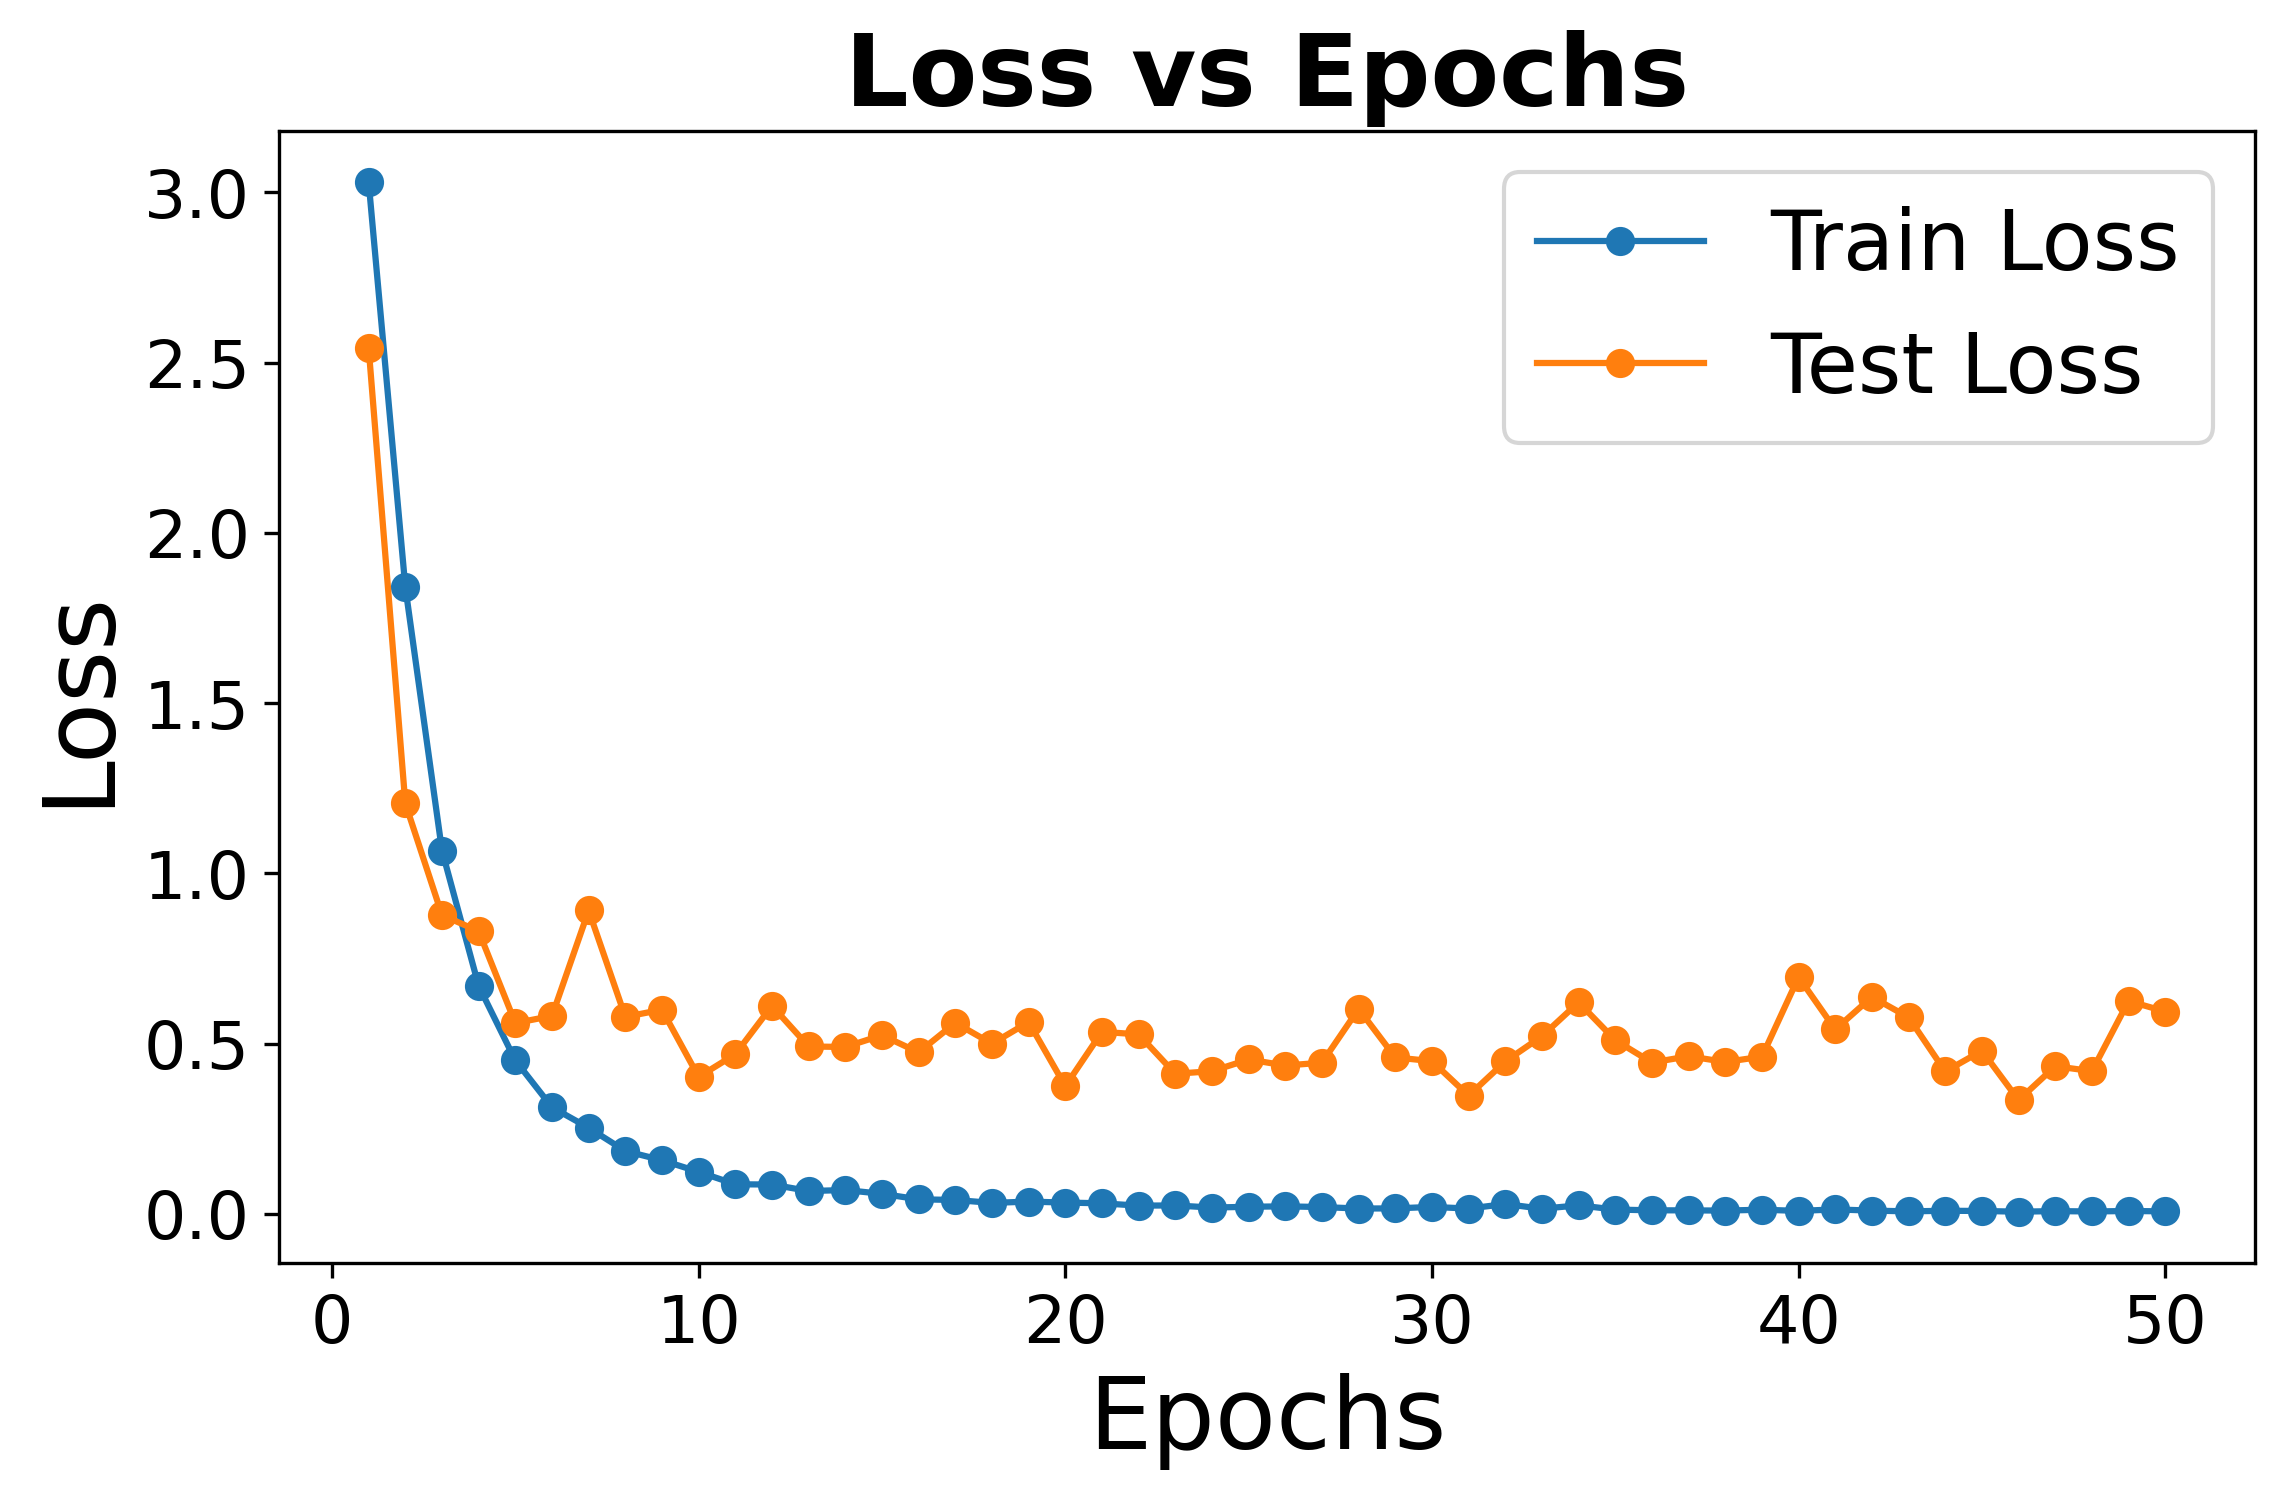

In [24]:
import seaborn as sns

from matplotlib import RcParams


myrcparams = RcParams({'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#EAEAF2',
          'axes.grid': True,
          'axes.labelcolor': '.15',
          'axes.linewidth': 0.0,
          'figure.facecolor': 'white',
          'font.family': ['serif'],
          'grid.color': 'white',
          'grid.linestyle': '--',
          'image.cmap': 'Greys',
          'legend.frameon': False,
          'legend.numpoints': 1,
          'legend.scatterpoints': 1,
          'lines.solid_capstyle': 'round',
          'text.color': '.15',
          'xtick.color': '.15',
          'xtick.direction': 'out',
          'xtick.major.size': 0.0,
          'xtick.minor.size': 0.0,
          'ytick.color': '.15',
          'ytick.direction': 'out',
          'ytick.major.size': 0.0,
          'ytick.minor.size': 0.0})

plt.style.library['seaborn-whitegrid']
RcParams.update(myrcparams)


fig, ax = plt.subplots(figsize =(8.5,5), dpi=300)

x = np.arange(1,len(train_loss)+1)

ax.plot(x, train_loss, '-o', label = "Train Loss", linewidth = 1.5)
ax.plot(x, test_loss, '-o', label = "Test Loss", linewidth = 1.5)

ax.set_xlabel("Epochs", fontsize = 24)
ax.set_ylabel("Loss", fontsize = 24)

ax.tick_params(
    axis = 'both',
    labelsize = 16
)
ax.legend(fontsize = 20)
ax.set_title("Loss vs Epochs", fontsize = 24, fontweight = 'bold')

plt.savefig("Loss vs Epochs.jpg", dpi = 300, bbox_inches = 'tight')
plt.savefig("Loss vs Epochs.pdf", dpi = 300, bbox_inches = 'tight')
plt.show()


In [25]:
print(train_loss)

[3.030217064751519, 1.8411539528104994, 1.067031376891666, 0.6695969038539462, 0.450971578558286, 0.3132725689146254, 0.25294413831498885, 0.18479375541210175, 0.15767892201741537, 0.12362476686636607, 0.08712584359778298, 0.086401191022661, 0.06725985018743409, 0.07024627717004882, 0.05909901195102268, 0.042940885863370366, 0.04107671748432848, 0.03238126987384425, 0.03627308106256856, 0.033421667706635266, 0.031212172367506556, 0.024395810750623543, 0.025000099713603657, 0.018739412124786112, 0.02106018778350618, 0.022321165435843997, 0.02024343019972245, 0.015877871567176446, 0.01630572198579709, 0.020654997064007655, 0.015792031668954425, 0.029107454750272963, 0.015279284574919276, 0.02531278847406308, 0.012826860571901003, 0.010657812003046274, 0.01054882077086303, 0.009788505474312438, 0.012530268532120518, 0.008925076884528002, 0.013290747793184387, 0.009788855962041352, 0.007584614058335622, 0.009283812250941992, 0.008763786508805223, 0.006620245364805062, 0.008330169547763135,

In [26]:
print(test_loss)

[2.543518304824829, 1.205586353937785, 0.8779000838597616, 0.8301329414049784, 0.5606227318445841, 0.581477701663971, 0.8911625842253367, 0.5787720183531443, 0.5998096664746603, 0.4023984521627426, 0.4690704196691513, 0.6112683415412903, 0.49184905489285785, 0.4903285602728526, 0.5249206026395162, 0.4745120902856191, 0.5613044798374176, 0.49989909927050274, 0.5635225673516592, 0.37518109877904254, 0.5348275899887085, 0.5274103581905365, 0.41164063413937885, 0.4193165401617686, 0.4536123176415761, 0.43589555223782855, 0.444189449151357, 0.6022857129573822, 0.45959384242693585, 0.44874632358551025, 0.3473723034063975, 0.447895348072052, 0.5219420890013377, 0.6215183933575948, 0.5103122691313425, 0.44465090831120807, 0.4631731112798055, 0.4463031391302745, 0.4619031449158986, 0.6955957015355428, 0.5417901873588562, 0.6374834179878235, 0.5772871573766073, 0.4183800866206487, 0.4793003797531128, 0.3340912039081256, 0.4338285227616628, 0.41933977603912354, 0.6253451208273569, 0.5943815211455

In [37]:
idx_to_class = inv_map = {v: k for k, v in test.class_to_idx.items()}

correct = []
pred = []

ResNet_34.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        # if cuda:
        #   data, target = data.cuda(), target.cuda()
        
        out = ResNet_34(data)


        for _,i in enumerate(out):

            pred.append(torch.argmax(i).cpu().item())
            correct.append(target[_].cpu().item())

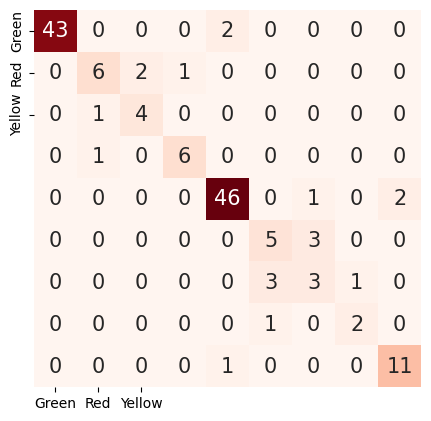

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# conf = confusion_matrix(y_pred= pred, y_true = correct)

# fig,ax = plt.subplots(figsize = (15,15))

# plt.imshow(conf, interpolation='none', cmap = 'YlOrRd_r')


conf = confusion_matrix(pred,correct)


plt.figure(figsize=(5,5),dpi=100)

sns.heatmap(conf,cmap='Reds',cbar=False,annot=True,
            xticklabels=['Green','Red','Yellow'],
            yticklabels=['Green','Red','Yellow'],
            annot_kws={'size':15,'weight':'normal'})
plt.show()

In [39]:
print(correct)

[4, 5, 1, 3, 5, 4, 2, 3, 0, 4, 8, 0, 8, 4, 3, 0, 0, 4, 5, 6, 8, 6, 4, 4, 0, 3, 1, 4, 4, 4, 4, 0, 5, 4, 2, 8, 0, 0, 6, 0, 4, 0, 5, 4, 0, 0, 0, 0, 4, 2, 0, 8, 0, 5, 4, 0, 2, 4, 0, 4, 4, 4, 8, 1, 4, 4, 3, 4, 0, 0, 1, 0, 2, 1, 8, 4, 5, 4, 4, 4, 2, 3, 8, 4, 4, 4, 4, 7, 5, 0, 4, 8, 0, 8, 4, 0, 1, 4, 0, 4, 0, 0, 6, 4, 4, 0, 0, 0, 4, 0, 4, 4, 4, 4, 0, 8, 0, 0, 8, 0, 7, 5, 6, 0, 1, 6, 4, 4, 0, 4, 4, 0, 4, 0, 6, 0, 3, 4, 4, 0, 0, 0, 8, 7, 1]


In [44]:
print(pred)

[4, 7, 1, 3, 5, 4, 1, 3, 0, 0, 4, 0, 8, 4, 3, 0, 0, 4, 5, 4, 8, 6, 4, 4, 0, 1, 1, 4, 4, 4, 4, 0, 5, 0, 2, 8, 0, 0, 6, 0, 4, 0, 6, 8, 0, 0, 0, 0, 4, 1, 0, 8, 0, 5, 4, 0, 2, 4, 0, 4, 4, 4, 8, 1, 4, 4, 3, 4, 0, 0, 1, 0, 2, 2, 8, 4, 6, 4, 4, 4, 2, 3, 8, 4, 4, 4, 4, 6, 5, 0, 4, 8, 0, 4, 4, 0, 1, 4, 0, 4, 0, 0, 5, 4, 4, 0, 0, 0, 4, 0, 4, 4, 4, 4, 0, 8, 0, 0, 8, 0, 7, 6, 5, 0, 3, 5, 4, 4, 0, 4, 4, 0, 4, 0, 6, 0, 3, 4, 4, 0, 0, 0, 8, 7, 1]


In [27]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [32]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    #with torch.no_grad():
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [33]:
def calc_accuracy(model, dataloader):
    model.eval()
    # model.cuda()    
    
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    for idx, (inputs, labels) in enumerate(dataloader):
        
        #inputs, labels = inputs.float(), labels.long()
        # obtain the outputs from the model
        outputs = model.forward(inputs)
        prec1, prec5 = accuracy(outputs, labels, topk=(1, 5))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))

    return top1 ,top5


In [34]:
calc_accuracy(ResNet_34, test_loader)

(<__main__.AverageMeter at 0x7fa7ab24d6a0>,
 <__main__.AverageMeter at 0x7fa7ab24d5e0>)

In [41]:
test_loader = torch.utils.data.DataLoader(
    test, 
    batch_size= 1,
    shuffle=True
)

In [42]:
categories = [0,1,2,3,4,5,6,7,8]


top1 = 0
top5 = 0
with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        # if cuda:
        #   data, target = data.cuda(), target.cuda()
        out = ResNet_34(data)
        probabilities = torch.nn.functional.softmax(out[0], dim=0)
        top1_prob, top1_catid = torch.topk(probabilities, 1)
        prob_1 = []
        for i in range(top1_prob.size(0)):
            prob_1.append(categories[top1_catid[i]])
        if target[_].detach().cpu().numpy() in prob_1:
            top1+=1
        top5_prob, top5_catid = torch.topk(probabilities, 5)
        prob_5 = []
        for i in range(top5_prob.size(0)):
            prob_5.append(categories[top5_catid[i]])
        if target[_].detach().cpu().numpy() in prob_5:
            top5+=1
    print(top1,top5)

IndexError: index 16 is out of bounds for dimension 0 with size 1